# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)
Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Get helper functions

In [13]:
import sys
from contextlib import contextmanager

# Define a context manager to temporarily add a path to sys.path
@contextmanager
def temporary_sys_path_append(path):
    sys.path.append(path)  # Add the specified path to sys.path
    try:
        yield  # Allow code within the with-block to execute
    finally:
        # Ensure the path is removed after exiting the with-block
        sys.path.remove(path)

# Using the context manager to temporarily add a path to sys.path
with temporary_sys_path_append('..'):
    # Inside this block, you can import modules located in the added path
    from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
    # Use the function or perform actions with the imported module here

# Outside the with-block, the path is no longer in sys.path, limiting the change to the block

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster) 

## Visualizing a text dataset

In [70]:
import pandas as pd

# Leer el CSV asegurándose de que todos los datos sean cargados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Verificar el número de filas
print(f"Total rows in train_df: {len(train_df)}")
print(f"Total rows in test_df: {len(test_df)}")

Total rows in train_df: 7613
Total rows in test_df: 3263


In [60]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [61]:
# What dows the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [7]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [18]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)  # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:The last few days of summer are supposed to be the most fun so what's more fun then accidentally burning arm hair while playing w/ a lighter

---

Target: 0 (not real disaster)
Text:A staged locomotive wreck what could possibly go wrong? http://t.co/Ei9x4H8tHm

---

Target: 0 (not real disaster)
Text:@gregorysanders @USDOT &amp; the stat of high auto deaths applies to children in a vehicle. I guess they can out run lightrail better than adult

---

Target: 0 (not real disaster)
Text:And you wonder why he's injured every year https://t.co/XYiwR9JETl

---

Target: 0 (not real disaster)
Text:Ari's hints and snippets will be the death of me.

---



## Split data into training and validation sets

In [19]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [20]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [21]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # type: ignore

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None,  # how many words in the vocabulary (all of the different words in the text)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,  # create groups of n-words?
                                    output_mode="int",  # how to map tokens to numbers
                                    output_sequence_length=None,  # how long do you want your sequences to be
                                    pad_to_max_tokens=False)

In [27]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [26]:
# Setup text vectorization variables
max_vocab_length = 10000  # max number of words to have in our vocabulary
max_length = 15  # max length our sequences will be (e.g. how many words from a tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)

In [28]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [29]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [30]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
I can't bloody wait!! Sony Sets a Date For Stephen KingÛªs Û÷The Dark TowerÛª #stephenking #thedarktower http://t.co/J9LPdRXCDE  @bdisgusting

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8,   98,  261,  637, 8294, 2710,    3, 1089,   10, 3382,    1,
        6400, 1692, 7438, 8094]])>

In [31]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]  # most common words
bottom_5_words = words_in_vocab[-5:]  # least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") # should be padding, OOV (out of vocabulary), and the most common words in your training data
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding, we'are going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector of 100 long.
* `input_length` = length of the sequences being passed to the embedding layer

In [32]:
from tensorflow.keras import layers # type: ignore

embedding = layers.Embedding(input_dim=max_vocab_length,  # set input shape
                             output_dim=128,  # output shape
                             embeddings_initializer="uniform",  # default, initialize randomly
                             input_length=max_length)  # how long is each input

/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Get access to the most extensive sources of threat information right out of the box. Then easily add your own internal intelligence. #BHUSA

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04866168,  0.04592457, -0.04122709, ..., -0.02544199,
         -0.0043801 ,  0.0194922 ],
        [-0.02011389,  0.02760537,  0.03053558, ..., -0.03898197,
         -0.01355717, -0.00320054],
        [-0.03453988, -0.00615336,  0.02292676, ...,  0.03956347,
          0.0041219 ,  0.02776234],
        ...,
        [ 0.04665473, -0.00963645,  0.0368516 , ...,  0.007917  ,
         -0.02500012,  0.03272524],
        [ 0.03176905,  0.03938941,  0.03576026, ..., -0.00668488,
          0.03342588,  0.02660043],
        [ 0.02859076, -0.02891007,  0.02966419, ..., -0.04621713,
         -0.04660917, -0.01070106]]], dtype=float32)>

In [20]:
# Embedded version of our random sentence
sample_embed[0], sample_embed[0].shape  # check out the shape of our embedded sentence

(<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
 array([[ 0.02425699, -0.00273292,  0.02357972, ..., -0.00457346,
          0.00609293, -0.00508908],
        [-0.03381693, -0.04741812,  0.04547215, ...,  0.02507761,
         -0.02553782, -0.00522455],
        [-0.04279618, -0.00983522,  0.01600048, ..., -0.0063891 ,
         -0.03888643, -0.01203716],
        ...,
        [ 0.02425699, -0.00273292,  0.02357972, ..., -0.00457346,
          0.00609293, -0.00508908],
        [-0.01652466, -0.03677965, -0.01801758, ..., -0.0443346 ,
          0.02595044, -0.03073645],
        [-0.01652466, -0.03677965, -0.01801758, ..., -0.0443346 ,
          0.02595044, -0.03073645]], dtype=float32)>,
 TensorShape([15, 128]))

## Modelling a text dataset (running a series of experiments)

Now, we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?
Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑**Note:** It's a common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),  # convert words to numbers using tfidf
    ("clf", MultinomialNB())  # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate the baseline model on the validation dataset
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function...

Let's create one to compare our model's predictions with the truth labels using the following metrics: 
* Accuracy
* Precision
* Recall
* F1-score

In [37]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision * 100,
                     "recall": model_recall * 100,
                     "f1": model_f1 * 100}
    return model_results

In [25]:
# Get the baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
print(baseline_results)

{'accuracy': 79.26509186351706, 'precision': 81.11390004213173, 'recall': 79.26509186351706, 'f1': 78.6218975804955}


## Model 1: A simple dense model

In [26]:
# Create a tensorboard callback (need to create a new one for each model)
SAVE_DIR = "model_logs"

In [27]:
# Build model with Functional API
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)  # inputs are 1-dimensional strings
x = text_vectorizer(inputs)  # turn the input text into numbers
x = embedding(x)  # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)  # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)  # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [28]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240719-140945
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6372 - loss: 0.6484 - val_accuracy: 0.7572 - val_loss: 0.5313
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8142 - loss: 0.4625 - val_accuracy: 0.7887 - val_loss: 0.4721
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8610 - loss: 0.3554 - val_accuracy: 0.7900 - val_loss: 0.4605
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8903 - loss: 0.2879 - val_accuracy: 0.7874 - val_loss: 0.4697
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9195 - loss: 0.2356 - val_accuracy: 0.7769 - val_loss: 0.4757


In [31]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7642 - loss: 0.5048


[0.4757358431816101, 0.7769029140472412]

In [32]:
# Make some predictions and evaluate
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))  # squeeze removes single dimensions
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


{'accuracy': 77.69028871391076,
 'precision': 77.72431692902212,
 'recall': 77.69028871391076,
 'f1': 77.56776970544695}

In [33]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [34]:
# Get the weight matrix of the embedding layer
# (these are the numerical representations of each token in the training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)  # same size as vocab size and embedding_dim (each token is a embedding_dim size vector)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, Tensorflow has a handy tool called projector: https://projector.tensorflow.org/

In [35]:
# Create embedding files (we got this from TensorFlow documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

📖**Resources:** If you'd like to know more about embeddings. i'd encourage you to check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* Tensorflow's Word Embeddings guide: https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.



### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [36]:
# Create an LSTM model
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)  # return sequences set to True for stacking layers
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [37]:
# Get a summary of the model
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,497 (5.20 MB)

 Trainable params: 1,362,497 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240719-141004
Epoch 1/5


2024-07-19 14:10:06.172826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9129 - loss: 0.2829 - val_accuracy: 0.7782 - val_loss: 0.6017
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9442 - loss: 0.1636 - val_accuracy: 0.7822 - val_loss: 0.6524
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9566 - loss: 0.1171 - val_accuracy: 0.7782 - val_loss: 0.8436
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9617 - loss: 0.1033 - val_accuracy: 0.7651 - val_loss: 0.7614
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9633 - loss: 0.0839 - val_accuracy: 0.7703 - val_loss: 0.9613


In [40]:
# Make predictions with our LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


{'accuracy': 77.03412073490814,
 'precision': 77.11671866902317,
 'recall': 77.03412073490814,
 'f1': 76.86901866564683}

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 81.11390004213173,
 'recall': 79.26509186351706,
 'f1': 78.6218975804955}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [42]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64,return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [43]:
# Model summary
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 15, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,337 (5.15 MB)

 Trainable params: 1,350,337 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Comnpile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240719-141037
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9433 - loss: 0.2568 - val_accuracy: 0.7756 - val_loss: 0.7040
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9638 - loss: 0.0986 - val_accuracy: 0.7677 - val_loss: 0.7319
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9710 - loss: 0.0700 - val_accuracy: 0.7664 - val_loss: 0.9386
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9721 - loss: 0.0594 - val_accuracy: 0.7612 - val_loss: 1.2340
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9744 - loss: 0.0559 - val_accuracy: 0.7677 - val_loss: 1.1098


In [46]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


{'accuracy': 76.77165354330708,
 'precision': 76.74723453090631,
 'recall': 76.77165354330708,
 'f1': 76.68863186407148}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [47]:
# Build an RNN using the Bidirectional RNN
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [48]:
# Model summary
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20240719-141109
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9290 - loss: 0.2378 - val_accuracy: 0.7690 - val_loss: 0.8012
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9792 - loss: 0.0521 - val_accuracy: 0.7664 - val_loss: 0.9257
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9815 - loss: 0.0446 - val_accuracy: 0.7625 - val_loss: 1.1611
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9765 - loss: 0.0471 - val_accuracy: 0.7625 - val_loss: 1.2730
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9843 - loss: 0.0366 - val_accuracy: 0.7638 - val_loss: 1.2114


In [51]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


{'accuracy': 76.37795275590551,
 'precision': 76.39261289761721,
 'recall': 76.37795275590551,
 'f1': 76.24822674694383}

## Convolution Neural Networks for text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our images data but bow we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [52]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers # type: ignore

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))  # turn target sentence into embedding
conv1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu", padding="valid")  # convolve over target sequence 5 words at a time
conv1d_output = conv1d(embedding_test)  # pass the embedded sequence to the convolutional layer
max_pool = layers.GlobalMaxPool1D()  # get the most important features
max_pool_output = max_pool(conv1d_output)  # reduce the dimensions of the data
embedding_test.shape, conv1d_output.shape, max_pool_output.shape

W0000 00:00:1721409103.859328   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.904022   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.910918   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.925437   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.932949   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.939466   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.946474   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.953894   85582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721409103.960888   85582 gp

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [53]:
# Create 1D convolutional model to process sequences
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20240719-141205
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9825 - loss: 0.0432 - val_accuracy: 0.7677 - val_loss: 1.1639
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9829 - loss: 0.0399 - val_accuracy: 0.7585 - val_loss: 1.2559
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9820 - loss: 0.0388 - val_accuracy: 0.7677 - val_loss: 1.2141
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9808 - loss: 0.0396 - val_accuracy: 0.7677 - val_loss: 1.2108
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9820 - loss: 0.0384 - val_accuracy: 0.7625 - val_loss: 1.2731


In [56]:
# Make predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


{'accuracy': 76.24671916010499,
 'precision': 76.29611993882945,
 'recall': 76.24671916010499,
 'f1': 76.08791530897156}

## Model 6: Tensorflow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder

In [57]:
import tensorflow_hub as hub 

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607499 ... -0.03242779 -0.04575738
   0.05370456]
 [ 0.0508086  -0.01652431  0.01573778 ...  0.00976658  0.03170119
   0.01788118]], shape=(2, 512), dtype=float32)


In [73]:
# Create a Keras layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [74]:
# Fixing keras 3.x.x bug
import tf_keras as keras

# Create model using the Sequential API
model_6 = keras.Sequential([
    sentence_encoder_layer,
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_22 (Dense)            (None, 64)                32832     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [75]:
# Train a model with the USE pretrained layer
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)#,
                              #callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_USE")]
                              )

Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.5087 - accuracy: 0.7774 - val_loss: 0.4481 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.4158 - accuracy: 0.8162 - val_loss: 0.4385 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.4014 - accuracy: 0.8228 - val_loss: 0.4372 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.3931 - accuracy: 0.8263 - val_loss: 0.4293 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3859 - accuracy: 0.8321 - val_loss: 0.4271 - val_accuracy: 0.8189


In [76]:
# Make predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

24/24 [==============================] - 1s 25ms/step


{'accuracy': 81.88976377952756,
 'precision': 81.98576982951774,
 'recall': 81.88976377952756,
 'f1': 81.79030717265692}

In [ ]:
# Base model results
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 81.11390004213173,
 'recall': 79.26509186351706,
 'f1': 78.6218975804955}

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [23]:
# Create subsets of 10% of the training data
train_sentences_10_percent = train_sentences[:int(0.1 * len(train_sentences))]
train_labels_10_percent = train_labels[:int(0.1 * len(train_labels))]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [78]:
# Check the number of targets in our subset of data
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
Name: count, dtype: int64

In [82]:
# Clone model_6 but reset the weights
model_7 = keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              #callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent")]
                              )

Epoch 1/5
22/22 [==============================] - 4s 67ms/step - loss: 0.6729 - accuracy: 0.6774 - val_loss: 0.6499 - val_accuracy: 0.7598
Epoch 2/5
22/22 [==============================] - 1s 57ms/step - loss: 0.6039 - accuracy: 0.8131 - val_loss: 0.5918 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 62ms/step - loss: 0.5288 - accuracy: 0.8175 - val_loss: 0.5378 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 1s 59ms/step - loss: 0.4655 - accuracy: 0.8277 - val_loss: 0.5046 - val_accuracy: 0.7848
Epoch 5/5
22/22 [==============================] - 1s 52ms/step - loss: 0.4226 - accuracy: 0.8307 - val_loss: 0.4884 - val_accuracy: 0.7795


In [84]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

24/24 [==============================] - 1s 25ms/step


{'accuracy': 77.95275590551181,
 'precision': 78.08713829501961,
 'recall': 77.95275590551181,
 'f1': 77.776991732408}

In [ ]:
# Compare model results 6 and 7
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 81.1513075854206,
 'recall': 81.10236220472441,
 'f1': 81.0153774429212}

## Comparing the performance of each of our models

In [93]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,81.113900,79.265092,78.621898
model_1,77.690289,77.724317,77.690289,77.567770
model_2,77.034121,77.116719,77.034121,76.869019
model_3,76.771654,76.747235,76.771654,76.688632
model_4,76.377953,76.392613,76.377953,76.248227
model_5,76.246719,76.296120,76.246719,76.087915
model_6,81.758530,81.807264,81.758530,81.678452
model_7,77.952756,78.087138,77.952756,77.776992


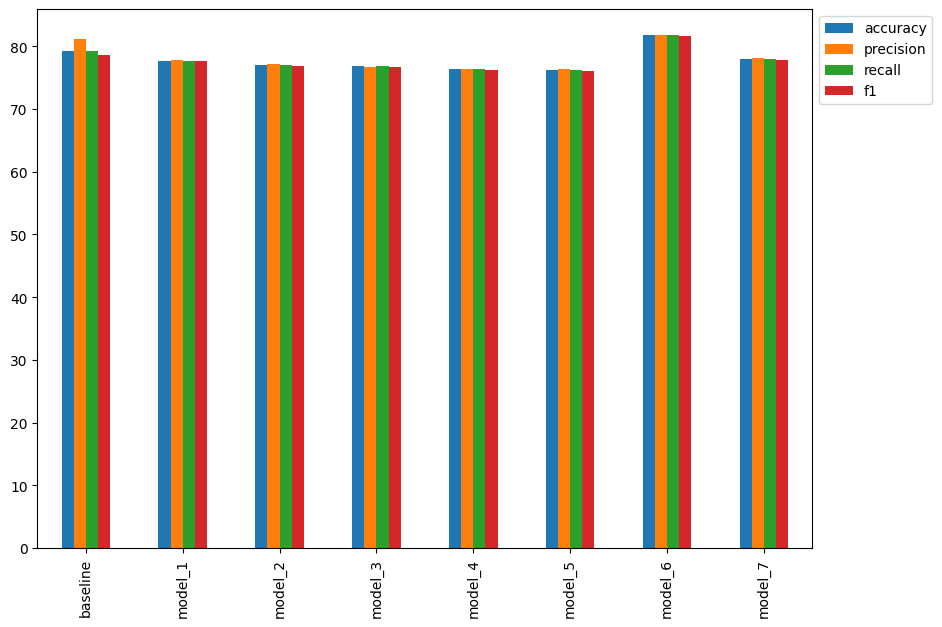

In [94]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

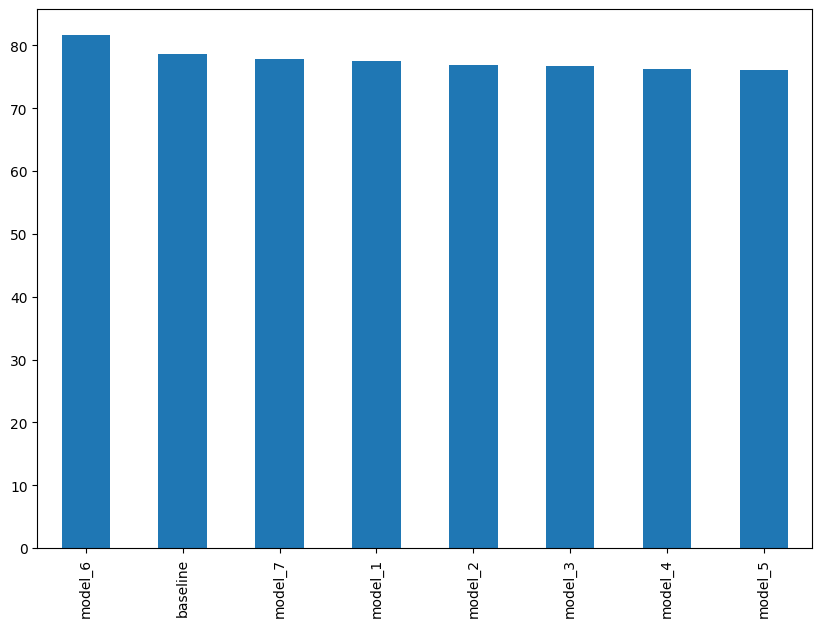

In [95]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SaveModel` format (this is the default when using TensorFlow)

In [96]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6_USE.h5")

/home/gus/.local/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [97]:
# Load model with custom Hub Layer (required for HDF5 format)
import tensorflow_hub as hub

loaded_model_6 = keras.models.load_model("model_6_USE.h5",
                                         custom_objects={"KerasLayer": hub.KerasLayer}) # required for loading in the Hub layer

In [98]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 39ms/step - loss: 0.4262 - accuracy: 0.8176


[0.4261632263660431, 0.817585289478302]

In [101]:
# Save model 7 to SavedModel format (default)
model_6.save("model_6_USE_10_percent_SavedModel")

INFO:tensorflow:Assets written to: model_6_USE_10_percent_SavedModel/assets


INFO:tensorflow:Assets written to: model_6_USE_10_percent_SavedModel/assets


In [103]:
# Load in a model from SavedModel format
loaded_model_6 = keras.models.load_model("model_6_USE_10_percent_SavedModel")

In [104]:
# Evaluate the loaded SavedModel format
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 40ms/step - loss: 0.4262 - accuracy: 0.8176


[0.42616337537765503, 0.817585289478302]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closet to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.99 (really close to 1) and viceversa.

In [105]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences, "target": val_labels, "pred": model_6_preds, "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.212385
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.832702
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990789
3,@camilacabello97 Internally and externally scr...,1,0.0,0.179733
4,Radiation emergency #preparedness starts with ...,1,1.0,0.794939


In [110]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.941121
759,FedEx will no longer transport bioterror patho...,0,1.0,0.923932
628,@noah_anyname That's where the concentration c...,0,1.0,0.873802
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.869682
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.866447
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.866147
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.862897
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.832702
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827445
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.826077


In [112]:
most_wrong.tail(10) # false negatives

,text,target,pred,pred_prob
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.064655
221,going to redo my nails and watch behind the sc...,1,0.0,0.062809
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.061039
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.053200
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.050239
59,You can never escape me. Bullets don't harm me...,1,0.0,0.048715
233,I get to smoke my shit in peace,1,0.0,0.048320
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038131
38,Why are you deluged with low self-image? Take ...,1,0.0,0.033785
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.027525


In [113]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 0, Pred: 1, Prob: 0.9411214590072632
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9239324331283569
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8738017082214355
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8696823716163635
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8664467334747314
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8661472797393799
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Pr

In [114]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0, Prob: 0.06465517729520798
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.06280933320522308
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06103905290365219
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05319954454898834
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.050239257514476776
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.04871534928679466
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.048320051282644

## Making predictions on the test dataset

In [115]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 161ms/step
Pred: 1, Prob: 0.9686403870582581
Text:
Severe Thunderstorm Warnings have been cancelled in central Oklahoma. Still expect 50 mph winds penny sized hail

----

1/1 [==============================] - 0s 77ms/step
Pred: 0, Prob: 0.37172064185142517
Text:
Watch Steaks Being Grilled Over Molten Hot Lava http://t.co/yxns3IiXjv http://t.co/lcM66dHn1l

----

1/1 [==============================] - 0s 56ms/step
Pred: 1, Prob: 0.6709924340248108
Text:
@JoeNBC IRAN: NO SNCTIONS INCL MILTARY$150BILNO INSPCTKPS HOSTAGESTHROSW ISRAEL TO GUTRKPS NUKE SITES U.S HLPS W/NUKES GET 'ZERO!'

----

1/1 [==============================] - 0s 62ms/step
Pred: 0, Prob: 0.10496115684509277
Text:
@jemmaswans i needed such a breather today oh my god i went on lunch and collapsed like a sack of bones in my car

----

1/1 [==============================] - 0s 323ms/step
Pred: 0, Prob: 0.33495721220970154
Text:
S3XLEAK!!!
Ph0tos of 19yrs old Ash@wo lady in Festac to

In [116]:
print(test_samples)

['Severe Thunderstorm Warnings have been cancelled in central Oklahoma. Still expect 50 mph winds penny sized hail', 'Watch Steaks Being Grilled Over Molten Hot Lava http://t.co/yxns3IiXjv http://t.co/lcM66dHn1l', "@JoeNBC IRAN: NO SNCTIONS INCL MILTARY$150BILNO INSPCTKPS HOSTAGESTHROSW ISRAEL TO GUTRKPS NUKE SITES U.S HLPS W/NUKES GET 'ZERO!'", '@jemmaswans i needed such a breather today oh my god i went on lunch and collapsed like a sack of bones in my car', 'S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in Festac town from Delta exp0sed on BBM 5 leaked pictures... http://t.co/lUm4l65alz', 'the Burning Legion has returned', 'We need to stop paying attention to @drizzy body bagging @Meekmill and worry bout what happen to #SandraBland', 'A Dog Was Abandoned In A Thunderstorm. But Then A Neighbor Steps Up And Does THIS http://t.co/iR3OXEH7id', "It doesn't get any closer. Heavy rain just barely missed @TontitownGrape festival but lightning TOO CLOSE #TGF2015 http://t.co/d9PQIXaTX6", "@exot

## Exercises
https://github.com/mrdbourke/tensorflow-deep-learning#-08-introduction-to-nlp-natural-language-processing-in-tensorflow-exercises

### Model_1, Model_2, Model_5

Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.

In [19]:
# Rebuild model_1
from tensorflow.keras import layers # type: ignore

model_1 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation="sigmoid")
], name="model_1_dense")

# Compile model_1
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6598 - loss: 0.6462 - val_accuracy: 0.7546 - val_loss: 0.5332
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8127 - loss: 0.4598 - val_accuracy: 0.7835 - val_loss: 0.4720
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8596 - loss: 0.3513 - val_accuracy: 0.7953 - val_loss: 0.4557
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8945 - loss: 0.2777 - val_accuracy: 0.7861 - val_loss: 0.4612
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9090 - loss: 0.2450 - val_accuracy: 0.7861 - val_loss: 0.4796


In [20]:
# Rebuild model 2
model_2 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")
], name="model_2_LSTM")

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5


2024-07-23 11:01:22.180654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9171 - loss: 0.2777 - val_accuracy: 0.7861 - val_loss: 0.5084
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9472 - loss: 0.1544 - val_accuracy: 0.7848 - val_loss: 0.7259
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9467 - loss: 0.1410 - val_accuracy: 0.7795 - val_loss: 0.6969
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9601 - loss: 0.1118 - val_accuracy: 0.7769 - val_loss: 0.8182
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9713 - loss: 0.0743 - val_accuracy: 0.7690 - val_loss: 1.0474


In [22]:
# Rebuild model 5
model_5 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    layers.Conv1D(64, kernel_size=5, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation="sigmoid")
], name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9375 - loss: 0.1800 - val_accuracy: 0.7703 - val_loss: 0.9186
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9797 - loss: 0.0621 - val_accuracy: 0.7612 - val_loss: 1.0060
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9813 - loss: 0.0466 - val_accuracy: 0.7572 - val_loss: 1.0591
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9767 - loss: 0.0518 - val_accuracy: 0.7572 - val_loss: 1.0955
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9808 - loss: 0.0466 - val_accuracy: 0.7598 - val_loss: 1.1439


### Baseline with 10%
Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [28]:
# Retrain baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0_retrained = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0_retrained.fit(train_sentences_10_percent, train_labels_10_percent)

# Evaluate the retrained baseline model
baseline_score_retrained = model_0_retrained.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score_retrained*100:.2f}%")

Our baseline model achieves an accuracy of: 70.21%


In [31]:
# Evaluate the baseline model on the validation dataset
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


### Fine-tunning TF Hub Universal
Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

In [7]:
# Import TF Hub USE
import tensorflow_hub as hub

sentence_encoder_layer_true = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True, # fine-tune USE
                                        name="USE")

In [ ]:
# Fixing keras 3.x.x bug
import tf_keras as keras

# Rebuild model_6
model_6_retrained = keras.Sequential([
    sentence_encoder_layer_true,
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6_retrained.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_6_retrained.fit(train_sentences_10_percent,
                      train_labels_10_percent,
                      epochs=5,
                      batch_size=16,  # Try reducing the batch size
                      validation_data=(val_sentences, val_labels))

Training this makes no sense, no GPU can support the memory allocation needed for the model. But I can make a model differently to fine-tunning it

In [34]:
# Rebuild model_6
import tf_keras as keras

model_6_retrained = keras.Sequential([
    sentence_encoder_layer_true,
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# trainable=True
for layer in model_6_retrained.layers:
    layer.trainable = True

# Freeze all layers except for the last 5
for layer in model_6_retrained.layers[:-5]:
    layer.trainable = False

# Compile the model
model_6_retrained.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.Adam(),
                          metrics=["accuracy"])

# Fit the model
model_6_retrained.fit(train_sentences,
                      train_labels,
                      epochs=5,
                      batch_size=16,  # Try reducing the batch size
                      validation_data=(val_sentences, val_labels))

Epoch 1/5


I0000 00:00:1721746236.408436   29442 service.cc:146] XLA service 0x7f7fdd8d9aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721746236.408486   29442 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-07-23 11:50:36.414232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 11:50:36.443419: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
I0000 00:00:1721746236.540931   29442 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


429/429 [==============================] - 19s 34ms/step - loss: 0.4776 - accuracy: 0.7794 - val_loss: 0.4602 - val_accuracy: 0.7979
Epoch 2/5
429/429 [==============================] - 15s 34ms/step - loss: 0.4183 - accuracy: 0.8175 - val_loss: 0.4398 - val_accuracy: 0.8084
Epoch 3/5
429/429 [==============================] - 15s 35ms/step - loss: 0.3976 - accuracy: 0.8311 - val_loss: 0.4691 - val_accuracy: 0.7887
Epoch 4/5
429/429 [==============================] - 15s 35ms/step - loss: 0.3677 - accuracy: 0.8390 - val_loss: 0.4724 - val_accuracy: 0.8031
Epoch 5/5
429/429 [==============================] - 14s 33ms/step - loss: 0.3354 - accuracy: 0.8626 - val_loss: 0.4588 - val_accuracy: 0.8097


### Whole training set
Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?

In [50]:
# Retrain model_6 on full data
# Fixing keras 3.x.x bug
import tf_keras as keras

# Create model using the Sequential API
model_6 = keras.Sequential([
    sentence_encoder_layer,
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_6.fit(train_df_shuffled["text"].to_numpy(),
            train_df_shuffled["target"].to_numpy(),
            epochs=5)

Epoch 1/5
238/238 [==============================] - 8s 29ms/step - loss: 0.5053 - accuracy: 0.7725
Epoch 2/5
238/238 [==============================] - 7s 31ms/step - loss: 0.4147 - accuracy: 0.8164
Epoch 3/5
238/238 [==============================] - 7s 31ms/step - loss: 0.4010 - accuracy: 0.8215
Epoch 4/5
238/238 [==============================] - 8s 32ms/step - loss: 0.3926 - accuracy: 0.8261
Epoch 5/5
238/238 [==============================] - 7s 31ms/step - loss: 0.3863 - accuracy: 0.8304


In [66]:
# Make predictions
model_6_pred_probs = model_6.predict(test_df["text"].to_numpy())

# Create DataFrame with test sentences and model predictions
test_df["target"] = tf.squeeze(tf.round(model_6_pred_probs)).numpy()

# delete keyword and location columns
test_df = test_df.drop(["keyword", "location", "text"], axis=1)
test_df.head()

102/102 [==============================] - 2s 24ms/step


,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0


In [63]:
# Asegurarse de que todas las filas están siendo consideradas
print(f"Total rows in test_df: {len(test_df)}")

Total rows in test_df: 3263


In [67]:
# Create a submission DataFrame
submission_df = test_df[["id", "target"]]
submission_df["target"] = submission_df["target"].astype(int)

# Create a submission CSV file
submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


### Confusion matrix
Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

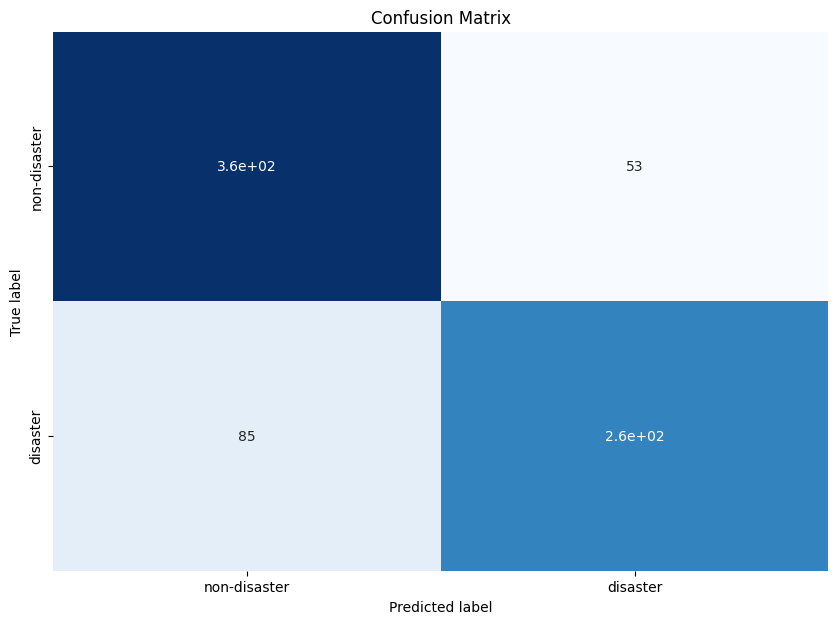

In [79]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(val_labels, model_6_preds)

# Turn the confusion matrix into a DataFrame
cm_df = pd.DataFrame(cm,
                     index=["non-disaster", "disaster"],
                     columns=["non-disaster", "disaster"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cbar=False, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()